# Notebook Setup

As usual, we need to install Drake and our KinovaStation software, so go ahead and run this cell to do so. 

In [34]:
#@title Run Notebook Setup
import importlib
import sys
import os
from urllib.request import urlretrieve
import subprocess
import shutil

assert 'google.colab' in sys.modules, "This notebook is meant to be run in google colab!"

drake_url = "https://drake-packages.csail.mit.edu/tmp/drake-0.27.0-pip-bionic.tar.gz"
if importlib.util.find_spec('pydrake') is None:
    # We're in colab and don't have pydrake, so install it on the cloud machine.
    if os.path.isdir('/opt/drake'):
        shutil.rmtree('/opt/drake')
    print("Installing Drake")
    urlretrieve(drake_url, 'drake.tar.gz')
    subprocess.run(['mkdir', '/opt/drake'])
    subprocess.run(['tar', '-xzf', 'drake.tar.gz', '-C', '/opt/drake'], check=True)
    
    print("Installing other dependencies")
    subprocess.run(["pip3", "install", "meshcat"])
    subprocess.run(['apt-get', 'update', '-o', 'APT::Acquire::Retries=4', '-qq'], check=True)
    with open("/opt/drake/share/drake/setup/packages-bionic.txt", "r") as f:
        packages = f.read().splitlines()
    subprocess.run(['apt-get', 'install', '-o',
                    'APT::Acquire::Retries=4', '-o', 'Dpkg::Use-Pty=0',
                    '-qy', '--no-install-recommends'] + packages,
                    check=True)
    
    v = sys.version_info
    path = f"/opt/drake/lib/python{v.major}.{v.minor}/site-packages"
    if importlib.util.find_spec('pydrake') is None:
        sys.path.append(path)

# Start a meshcat server
print("Starting Meshcat")
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=['--ngrok_http_tunnel'])

# Clone our github repo
install_path = '/opt/kinova_drake'
if not os.path.isdir(install_path):
    print("Cloning github repo")
    subprocess.run(['git','clone','https://github.com/vincekurtz/kinova_drake.git',install_path])
sys.path.append(install_path)

# Install open3d point cloud library
print("Installing Open3D")
subprocess.run(['pip3','install','open3d'])

print("Done!")

Starting Meshcat
Installing Open3D
Done!


# All About System Diagrams

In the previous notebook, we saw how a KinovaStation object from [this repository](https://github.com/vincekurtz/kinova_drake) could be used to model the robot in simulation. Now we'll take a closer look at how this works. 

First, let's create a simple KinovaStation instance that we can play around with. 

In [ ]:
from kinova_station import KinovaStation
station = KinovaStation(time_step=0.002)
station.SetupSinglePegScenario()
station.ConnectToMeshcatVisualizer(zmq_url=zmq_url)
station.Finalize()

You can find out the type of any object in python using the `type` command. Let's do that for our station object. 

In [ ]:
print(type(station))

You can see that this is an instance of a `KinovaStation` class, which is defined [here](https://github.com/vincekurtz/kinova_drake/blob/master/kinova_station/simulation_station.py). Furthermore, we can see that this class inherits from a pydrake system diagram class.

(Need a refresher on classes, objects, and inheritance in python? Check out [this tutorial](https://realpython.com/python3-object-oriented-programming/) or find another one online. If you find a really good tutorial, send it to me! )

In [ ]:
print(type(station).__bases__)

This `Diagram` class is part of [Drake](https://drake.mit.edu/), the underlying software that we use for modeling and control in simulation and on the actual robot. You can read more about the Diagram class in the [Drake documentation](https://drake.mit.edu/pydrake/pydrake.systems.framework.html?#pydrake.systems.framework.Diagram), or in [this tutorial](https://hub.gke2.mybinder.org/user/robotlocomotion-drake-inrx89fz/notebooks/tutorials/dynamical_systems.ipynb) but we'll provide a quick overview here. 

Basically, a `Diagram` consists of a bunch of blocks with input and output ports. Each block represents some sort of subsystem, which takes the inputs, runs some computations, and sends outputs. 

You can view a visual representation of a system diagram using the `plot_system_graphviz` command. Let's give that a try with our `station`:


In [ ]:
from pydrake.all import plot_system_graphviz
from matplotlib import pyplot as plt
plt.figure(figsize=(20,20))
plot_system_graphviz(station)
plt.show()

Wow, that looks complicated! Don't worry, you don't need to know the details of all of those components. One of the nice thing about system diagrams is that they can be *abstracted*. That is, we can think of the station itself as a block in a larger diagram with certain inputs and outputs. Then we can just consider these inputs and outputs, without worrying about the details of what is going on inside the station. 

We can see just the inputs and outputs of the station by adjusting the `max_depth` parameter:

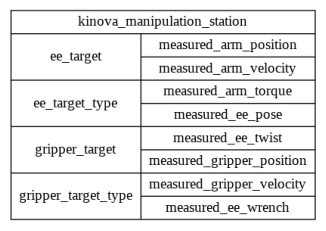

In [37]:
plot_system_graphviz(station, max_depth=0)
plt.show()

As you can see, our station has four inputs (listed on the left side) and eight outputs (listed on the right side). In the next section, we'll give a brief summary of each of these. 

# Inputs and Outputs of the `KinovaStation`

## Outputs

Let's first consider the system outputs. These are things that we can measure using sensors on the real robot. 

The first three outputs have to do with all the joints of the robot:

1. `measured_arm_position` - Provides all the joint angles of the robot. Our robot has 7 degrees-of-freedom (i.e., it's 7-DoF robot), so there are 7 joint angles to consider. These are stacked together in a vector which we call $\mathbf{q}$:
\begin{equation*}
    \mathbf{q} = 
    \begin{bmatrix}
        q_1 \\
        q_2 \\
        \vdots \\
        q_7
    \end{bmatrix},
\end{equation*}
where $q_1$ is the angle (in radians) of the first joint, $q_2$ is the angle of the second joint, and so on. 

2. `measured_arm_velocity` - Provides all the joint velocities of the robot. Each joint velocity is the rate of change in the corresponding joint angle. These are stacked together in a similar vector:
\begin{equation*}
    \mathbf{v} = 
    \begin{bmatrix}
        v_1 \\
        v_2 \\
        \vdots \\
        v_7
    \end{bmatrix},
\end{equation*}
with $v_1$ corresponding to the first joint, $v_2$ corresponding to the second joint, and so on. If you're familiar with calculus, you may recognize that $\mathbf{v}$ is the derivative of $\mathbf{q}$, so we often write $\mathbf{v} = \dot{\mathbf{q}}$.

3. `measured_arm_torque`

The next three outputs have to do with the *end-effector*. 

4. `measured_ee_pose`

5. `measured_ee_twist`

6. `measured_ee_wrench`

The final two outputs have to do with the gripper. 

7. `measured_gripper_position`

8. `measured_gripper_velocity`

## Inputs

# Creating a Custom Controller Block

# Connecting the Controller

# Coming Soon...
- Explain input-output ports
- Sending commands programmatically (controller class with inputs and outpus)
- Challenges (distribute throughout notebook)
    - What are the units for the joint velocity?
    - What is the difference between a pose and a position? Velocity and Twist?
    - Go back to the previous notebook and make a picture of the system diagram showing controller and station. Which input and output ports are used? Why do you think we chose those ports?
    - Send end-effector to specfic point
    - Move in a circle
    - Pick up block at known location